In [ ]:

# Import necessary libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# Upload the dataset (Google Colab specific)

from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
# Load the dataset

df = pd.read_csv("AirPassengers.csv", delimiter=',')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
print(df.columns)

Index(['Month', '#Passengers'], dtype='object')


 ## Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
#Passengers    0
dtype: int64


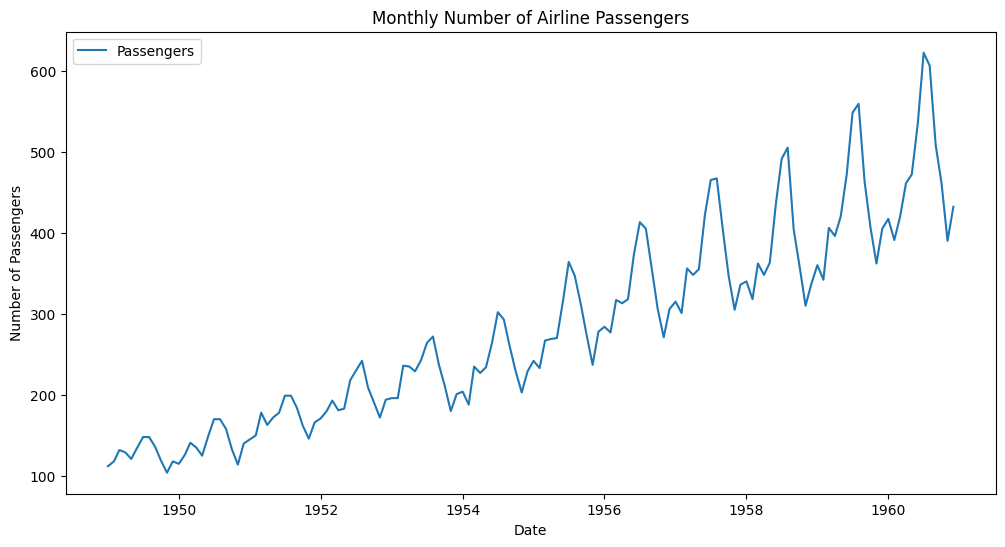

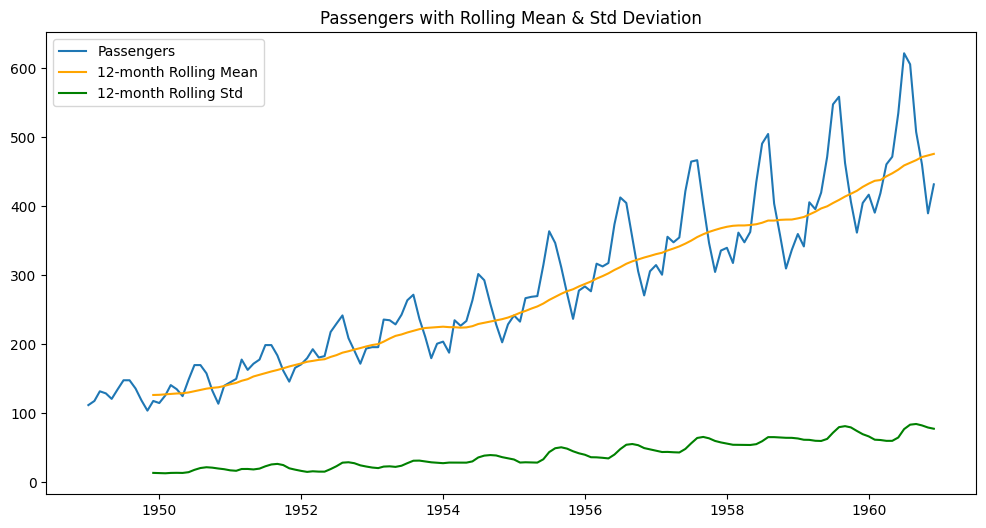

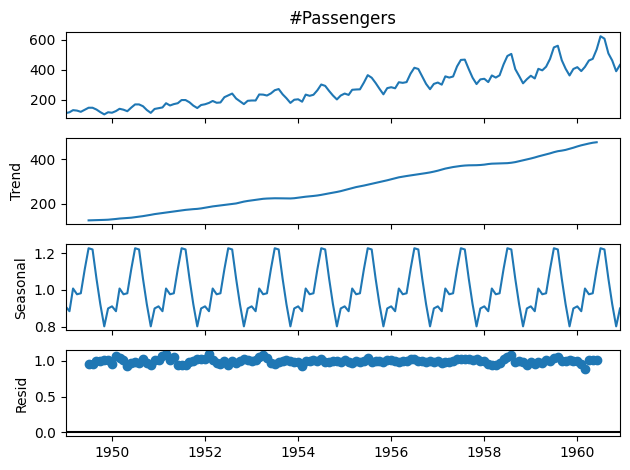

In [ ]:
# Basic info
print(df.info())
print(df.describe())

# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# 3. Check for missing values
print(df.isnull().sum())

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df.index, df['#Passengers'], label='Passengers')
plt.title('Monthly Number of Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Check seasonality & trend using rolling mean
df['Rolling_Mean_12'] = df['#Passengers'].rolling(window=12).mean()
df['Rolling_Std_12'] = df['#Passengers'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'], label='Passengers')
plt.plot(df['Rolling_Mean_12'], label='12-month Rolling Mean', color='orange')
plt.plot(df['Rolling_Std_12'], label='12-month Rolling Std', color='green')
plt.title('Passengers with Rolling Mean & Std Deviation')
plt.legend()
plt.show()

# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['#Passengers'], model='multiplicative')
result.plot()
plt.show()


In [ ]:
print(df.columns)


Index(['#Passengers', 'Rolling_Mean_12', 'Rolling_Std_12'], dtype='object')


## Preprocess data for LSTM


In [ ]:

# Extract passengers as a numpy array and scale
data = df['#Passengers'].values.reshape(-1, 1)  # Use '#Passengers' column (Month is index)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences and labels for supervised learning
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Use last 12 months to predict the next month
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split train and test sets (80% train)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, 1))

## Build and train LSTM model

In [ ]:
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define EarlyStopping callback to stop training if val_loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,             # increased epochs, EarlyStopping will stop training early if needed
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.1055 - val_loss: 0.1883
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0333 - val_loss: 0.0229
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0188 - val_loss: 0.0368
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0139 - val_loss: 0.0430
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0122 - val_loss: 0.0206
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0103 - val_loss: 0.0208
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0074 - val_loss: 0.0213
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0083 - val_loss: 0.0210
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0064 - val_loss: 0.0207
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0081 - val_loss: 0.0219
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0085 - val_loss: 0.0208
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0093 - val_l

## Evaluate on the Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
MSE: 520.522
RMSE: 22.815
MAE: 19.409
R^2: 0.918


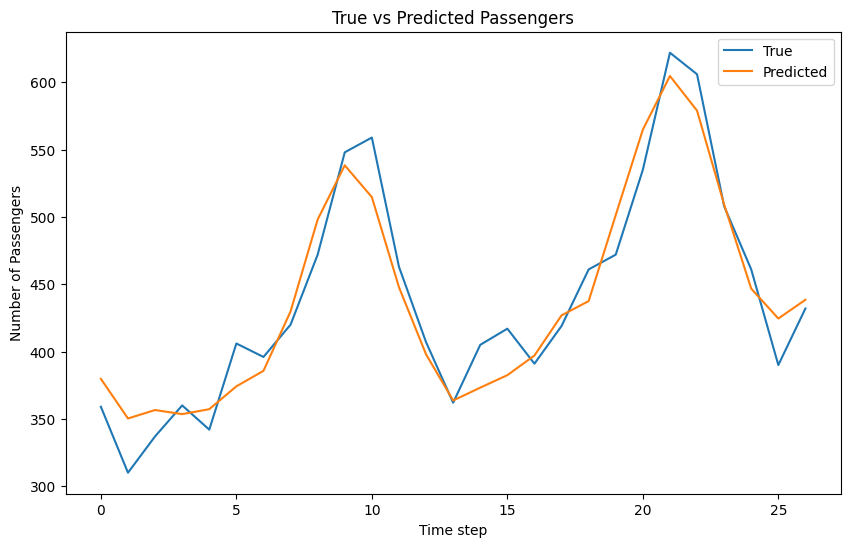

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and true values back to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")

# Plot true vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.title('True vs Predicted Passengers')
plt.xlabel('Time step')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()